In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation

from timescales.sim import sim_spikes_synaptic, exp_decay_func, sim_acf_cos
from timescales.est import compute_acf, fit_acf, fit_acf_cos, fit_psd

## Manuscript Figures

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - ~~Limits event-related application~~
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials are simulated, each with 2s of signal, simulating an event-related design.

In [2]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.025
var_noise = None
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
spikes_osc = np.zeros((n_trials, int(n_seconds * fs)))

for i in range(n_trials):
    
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          mu=10, var_noise=var_noise, return_sum=False)
    
    spikes[i] = _probs
    
    # Add oscillation
    #_cos = sim_bursty_oscillation(n_seconds, fs, 10, phase='max', burst_def='durations', 
    #                              burst_params=dict(n_cycles_burst=2, n_cycles_off=1))
    _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
    _cos -= _cos.min()
    _cos /= _cos.max()
    
    spikes_osc[i] = _probs + (_cos * .25)
    spikes_osc[i] = spikes_osc[i] / np.max(spikes_osc[i])
    
# Compute ACF
corrs = compute_acf(spikes, 500)
params_acf = fit_acf(corrs)
params_acf_mean = fit_acf(corrs.mean(axis=0))

corrs_osc = compute_acf(spikes_osc, 500)
params_acf_osc = fit_acf_cos(corrs_osc, fs)
params_acf_mean_osc = fit_acf_cos(corrs_osc.mean(axis=0), fs)

# Fit Spectra
f_range = (1, 200)
fooof_init = {'max_n_peaks': 0}

fg, knee_freq, knee_tau = fit_psd(spikes, fs, f_range, fooof_init)
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(spikes, fs, f_range, fooof_init, mode='mean')

fooof_init = {'max_n_peaks': 1}
fg_osc, knee_freq_osc, knee_tau_osc = fit_psd(spikes_osc, fs, f_range, fooof_init)
fg_mean_osc, knee_freq_mean_osc, knee_tau_mean_osc = fit_psd(spikes_osc, fs, f_range, fooof_init, mode='mean')

/home/rph/Projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


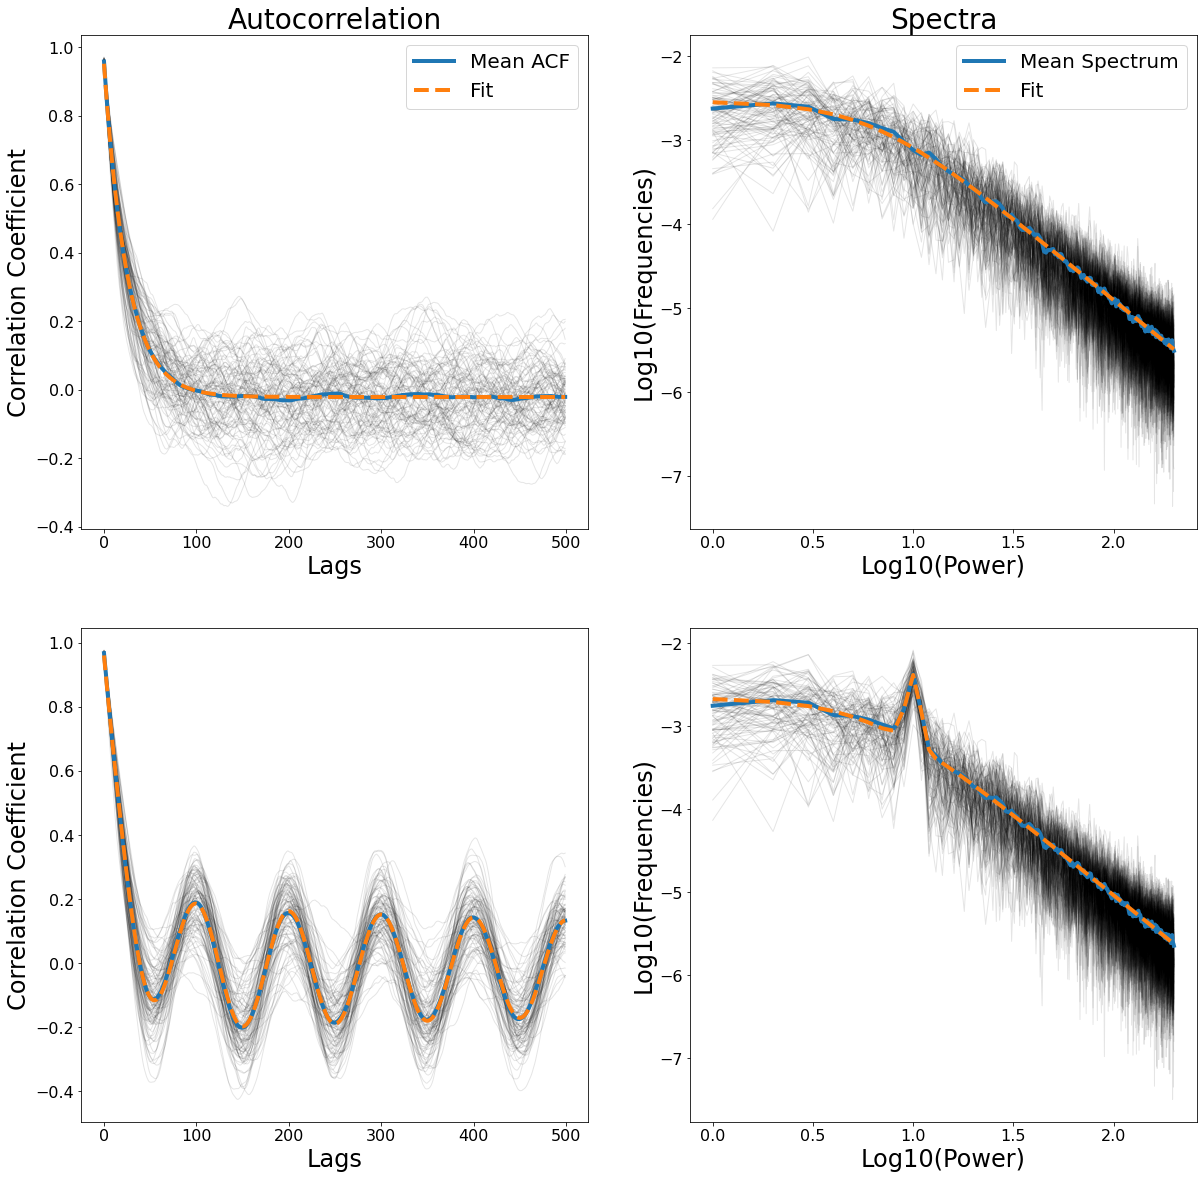

In [3]:
# Plot ACF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

for ind, c in enumerate(corrs):
    axes[0][0].plot(c, color='k', alpha=.1, lw=1)
for ind, c in enumerate(corrs_osc):
    axes[1][0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0][0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[1][0].plot(corrs_osc.mean(axis=0), label=f'Mean ACF', lw=4)


axes[0][0].set_xlabel('Lags', fontsize=24)
axes[1][0].set_xlabel('Lags', fontsize=24)
axes[0][0].set_ylabel('Correlation Coefficient', fontsize=24)
axes[1][0].set_ylabel('Correlation Coefficient', fontsize=24)
     
axes[0][0].tick_params(axis='x', labelsize=16)
axes[0][1].tick_params(axis='x', labelsize=16)
axes[1][0].tick_params(axis='x', labelsize=16)
axes[1][1].tick_params(axis='x', labelsize=16)
axes[0][0].tick_params(axis='y', labelsize=16)
axes[0][1].tick_params(axis='y', labelsize=16)
axes[1][0].tick_params(axis='y', labelsize=16)
axes[1][1].tick_params(axis='y', labelsize=16)

# Plot Spectra
for p in fg.power_spectra:
    axes[0][1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
for p in fg_osc.power_spectra:
    axes[1][1].plot(np.log10(fg_osc.freqs), p, color='k', alpha=.1, lw=1)
    
axes[0][1].plot(np.log10(fg.freqs), np.log10(np.mean(10**fg.power_spectra, axis=0)), lw=4, color='C0', label='Mean Spectrum')
axes[0][1].set_xlabel('Log10(Power)', fontsize=24)
axes[0][1].set_ylabel('Log10(Frequencies)', fontsize=24)


axes[1][1].plot(np.log10(fg_osc.freqs), np.log10(np.mean(10**fg_osc.power_spectra, axis=0)), lw=4, color='C0', label='Mean Spectrum')
axes[1][1].set_xlabel('Log10(Power)', fontsize=24)
axes[1][1].set_ylabel('Log10(Frequencies)', fontsize=24);

axes[0][0].set_title('Autocorrelation', fontsize=28)
axes[0][1].set_title('Spectra', fontsize=28);

# Plt fits
acf_fit = exp_decay_func(np.arange(1, len(corrs[0])+1), *params_acf_mean)
acf_cos_fit = sim_acf_cos(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean_osc)

axes[0][0].plot(acf_fit, label='Fit', color='C1', lw=4, ls='--')
axes[0][1].plot(np.log10(fg_mean.freqs), fg_mean.fooofed_spectrum_, label='Fit', color='C1', lw=4, ls='--')
axes[1][0].plot(acf_cos_fit, color='C1', lw=4, ls='--')
axes[1][1].plot(np.log10(fg_mean_osc.freqs), fg_mean_osc.fooofed_spectrum_, color='C1', lw=4, ls='--')


axes[0][0].legend(fontsize=20, loc='upper right')
axes[0][1].legend(fontsize=20, loc='upper right');
#plt.savefig('fig1.png')

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

In [4]:
from neurodsp.sim import sim_synaptic_kernel

n_seconds = 2
fs = 1000
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
mu = 50

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

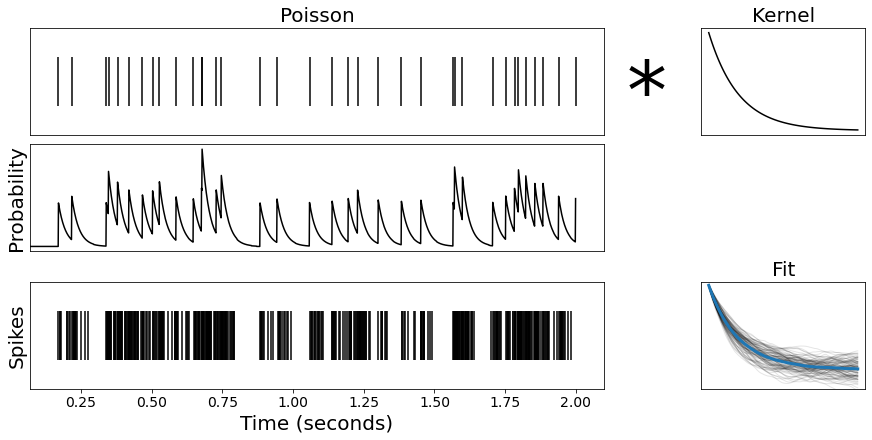

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 10)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)
ax5 = fig.add_subplot(gs[2, 8:])

ax0.eventplot(times[poisson], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson', size=20)
ax0.set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')


ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel, color='k')
ax2.set_title('Kernel', size=20)

ax3.plot(times, probs, color='k')
ax3.set_ylabel('Probability', size=20)
ax3.set_yticks([])
#ax3.set_xlabel('Time (seconds)', size=16)
ax3.get_xaxis().set_visible(False)
#ax3.set_xlim(-.25, 2.25)


ax4.eventplot(times[spikes], color='k')
ax4.set_ylabel('Spikes', size=20)
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=14)
ax4.set_xlabel('Time (seconds)', size=20)


#ax5.plot(acf_fit)

for ind, c in enumerate(corrs):
    ax5.plot(c[:125], color='k', alpha=.1, lw=1)
    
ax5.plot(corrs.mean(axis=0)[:125], lw=3)
ax5.set_ylim(-.25, 1)

ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.set_title('Fit', size=20);

### Figure 3

Performance of Different Methods

Function of:

- Amount of data (time & number of neurons)
- Oscillatiory Features
- Short vs Long Tau

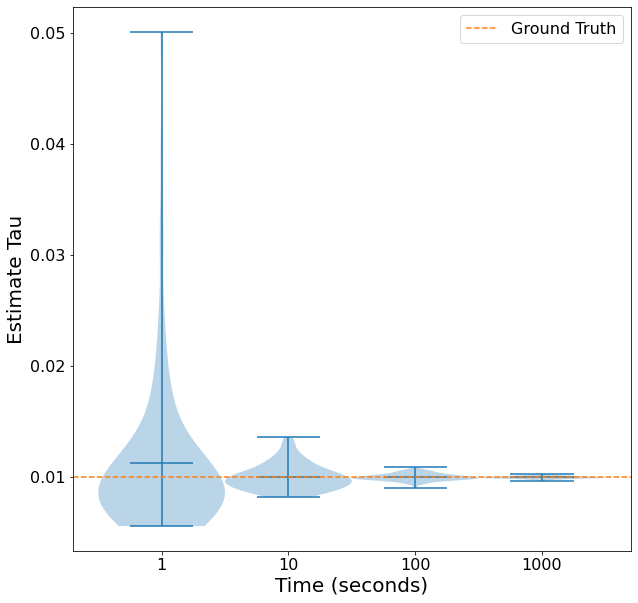

In [6]:
# Settings
fs = 1000
tau = 0.01
var_noise = 0

# Simulate Spikes
n_seconds = np.array([1, 10, 100, 1000])

params = np.zeros((len(n_seconds), 100))
for i in range(len(n_seconds)):
    
    for j in range(100):
        _probs, _spikes = sim_spikes_synaptic(n_seconds[i], fs, tau, n_neurons=1, return_sum=True)
        
        # Compute ACF
        corrs = compute_acf(_probs, 500)
        
        _params = fit_acf(corrs)

        params[i, j] = _params[0] / fs
        
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.violinplot([p for p in params], showmeans=True, widths=1)

ax.axhline(.01, label='Ground Truth', ls='--', color='C1')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels=['1', '10', '100', '1000'])

ax.set_xlabel('Time (seconds)', size=20)
ax.set_ylabel('Estimate Tau', size=20)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(fontsize=16);

### Figure 4

Proposed Workflow